In [1]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import collections
import functools
import itertools
import os
import pathlib
import sys
import textwrap

import datasets
import matplotlib.pyplot as plt
import numpy as np
import re
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import transformers
import tqdm

sys.path.append("..")
import bert_utils
import retrievers
import utils


print(tf.__version__)

comet_ml is installed but `COMET_API_KEY` is not set.
/usr/local/google/home/julesgm/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


2.3.1


In [2]:
# Prepare different HuggingFace objects that will definitely be needed.

kilt = datasets.load_dataset("kilt_tasks")
eli5 = {k.split("_")[0]: v for k, v in kilt.items() if "eli5" in k}
gpt2_tokenizer = transformers.GPT2TokenizerFast.from_pretrained("gpt2-xl")
print(f"Dataset split keys: {list(eli5.keys())}")

Reusing dataset kilt_tasks (/usr/local/google/home/julesgm/.cache/huggingface/datasets/kilt_tasks/all_tasks/1.0.0/821c4295a2c35db2847585918d9c47d7f028f1a26b78825d8e77cd3aeb2621a1)


Dataset split keys: ['train', 'validation', 'test']


In [3]:
# Load the configuration file for the retriever. This tells us where the reference file is and how many
# entries it has.

retriever_config = retrievers.REALMSave(
      **utils.from_json_file("../configs/retriever_configs/realm_configs/local_cloudtop/open_source.json")
)

In [4]:
# Load the reference text DB

block_records_path=retriever_config.text_records
num_block_records=retriever_config.num_block_records
    
blocks_dataset = tf.data.TFRecordDataset(block_records_path,
                                       # Value taken from the REALM
                                       # code.
                                       buffer_size=512 * 1024 * 1024)

blocks_dataset = blocks_dataset.batch(num_block_records,
                                      drop_remainder=True)

blocks = tf.data.experimental.get_single_element(blocks_dataset)

In [5]:
# Convert the DB to numpy

np_blocks = blocks.numpy()

In [6]:
# Extract the lengths of a number of entries

lengths = []
for line in tqdm.tqdm(np_blocks[:100000]):
    lengths.append(len(gpt2_tokenizer(line.decode())["input_ids"]))

100%|██████████| 100000/100000 [03:24<00:00, 488.65it/s]


In [7]:
# Compute maximum lengths of a number of centiles
# This is really quick and dirty, inefficient code.

counter = collections.Counter(lengths)
by_len = sorted(counter.items(), key=lambda pair: pair[0])
maxes = []
for max_percentage in (.8, .85, .875, .9, .925, .95, .975):
    accum = {}
    accum_v = 0
    for len_, count in by_len:
        if accum_v < max_percentage:
            accum_v += count / len(lengths)
            accum[len_] = accum_v
    max_ = max(accum.items(), key=lambda x: x[0])
    maxes.append(max_)
    print(max_)

(275, 0.8048799999999995)
(279, 0.8632899999999996)
(280, 0.8760399999999996)
(283, 0.9098399999999995)
(285, 0.9286999999999995)
(288, 0.9508699999999995)
(294, 0.9771099999999995)


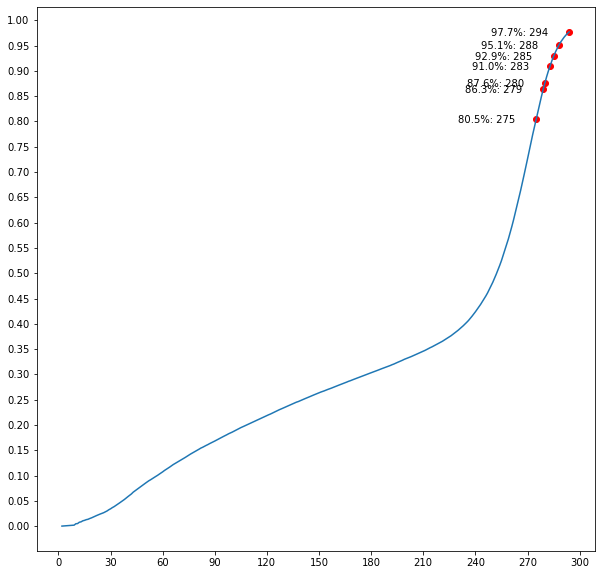

In [8]:
# We plot the results.

plt.figure(figsize=(10, 10))
plt.plot(accum.keys(), accum.values())
for x, y in maxes:
    plt.scatter(x=(x,), y=(y,), color="red")
plt.yticks(np.linspace(0, 1, 21))
plt.xticks(np.linspace(0, 300, 11))
for x, y in maxes:
    plt.text(x - 45, y- 0.0075, f"{y:0.1%}: {x}", size=10)